# OSK
## Penilaian Udang Vaname

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
from PIL import Image
import skimage
from skimage import io, color, feature
from skimage.filters import rank
from skimage.feature import greycomatrix, greycoprops
import os
import sys
import cv2

In [10]:
def image_open(filepath):
    img = Image.open(filepath)
    return np.array(img)

def plot (img):
    d = img.shape
    if len(d) == 2:
        r,c = img.shape
    else:
        r,c, de = img.shape
    if r > c:
        figs = 10,(c/r)*10
    else:
        figs = (c/r)*10,10
    fig = plt.figure(figsize=figs)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray')

    plt.show()

def rgb2lab(img):
    img = color.rgb2lab(img, illuminant='D50')
    return img

def rgb2hsv(img):
    img = clr.rgb_to_hsv(img)
    return img

def grayscale(img):
    img = 0.2989 * img[:,:,0] + 0.5870 * img[:,:,1] + 0.1140 * img[:,:,2]
    return img

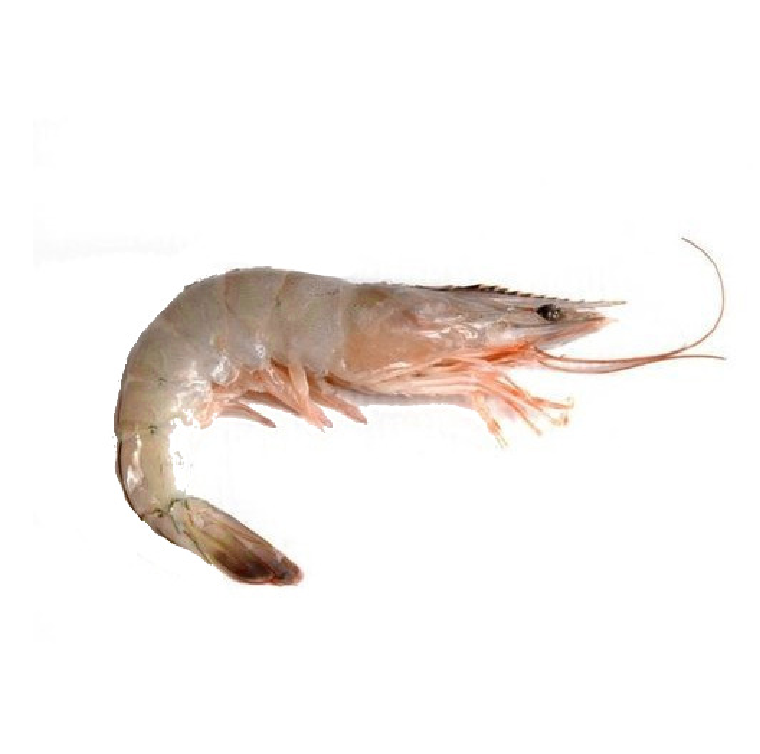

In [59]:
filepath = "image/kategori1/good9.jpg"

img = image_open(filepath)

plot(img)

In [60]:
def level_thresh(img, level=17):
    image = np.array(img)
    if len(image.shape) > 2:
        image = grayscale(image)
    high = 255
    diff = int(high // level)
    
    while(1):
        low = high - diff if (high - diff) >= 0 else 0
        to_low = np.array([low])
        to_high = np.array([high])
        mask = cv2.inRange(image, to_low, to_high)
        image[mask > 0] = high
        high -= diff
        
        if (low <= 0):
            break
    return image.astype(int)

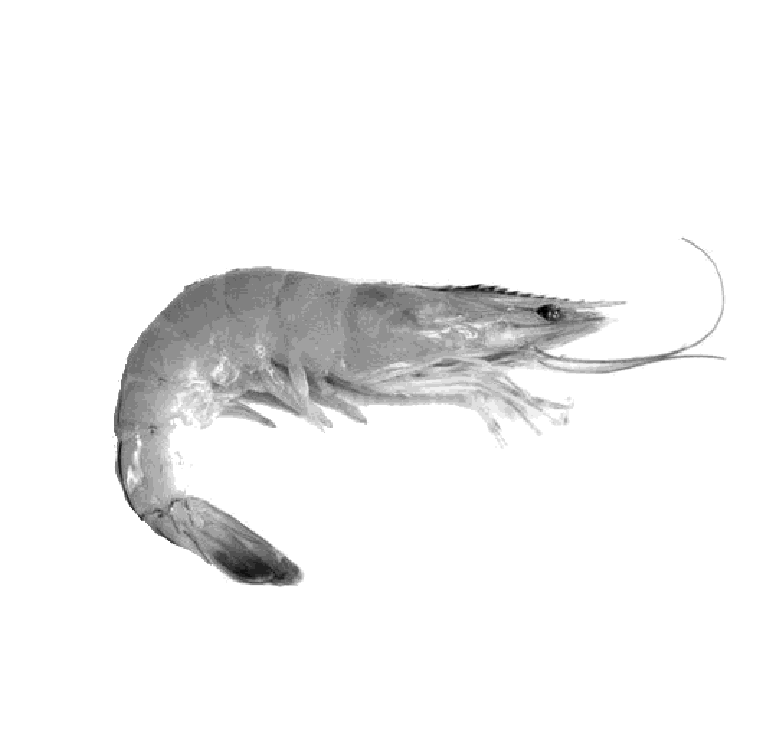

In [64]:
new_image = level_thresh(img,17)
plot(new_image)

In [65]:
def replace_background(img, mask, threshold=235, replacement=[0,0,0]):
    """Remove white background into pure black background
    
    Input = PIL Image Array
            Threshold (Optional)"""
    
    img[mask==0] = 0
    img = Image.fromarray(img)
    src = img.split()
        
    mask0 = src[0].point(lambda i: i < threshold)
    mask1 = src[1].point(lambda i: i < threshold)
    mask2 = src[2].point(lambda i: i < threshold)

    img = np.array(img)
    mask0 = np.array(mask0)
    mask1 = np.array(mask1)
    mask2 = np.array(mask2)
    
    img[mask0 + mask1 + mask2 < 2] = replacement
    
    return img

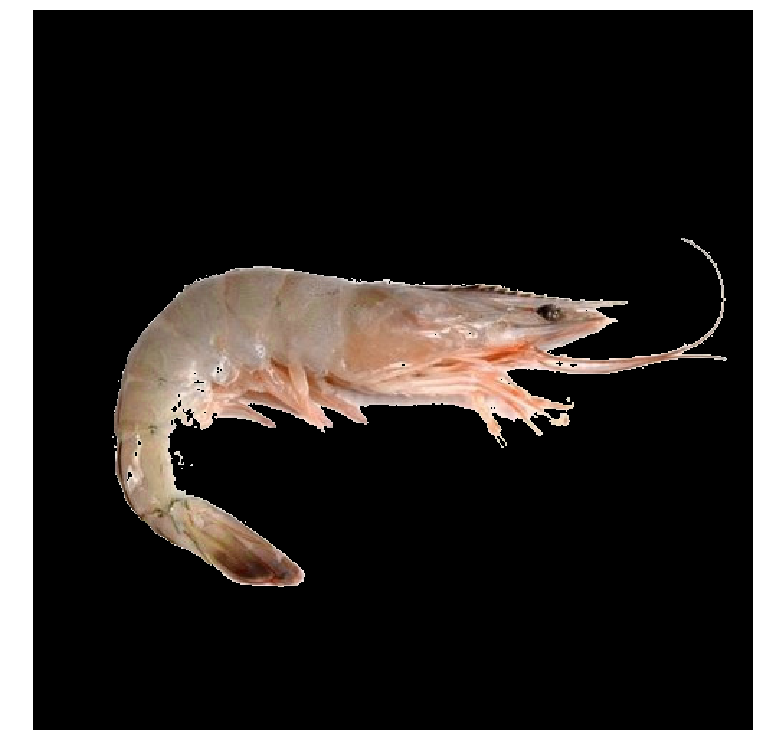

In [66]:
new_img = replace_background(img, new_image)
plot(new_img)

In [34]:
def getColorMean(img, dimension, colorrange="rgb", ignore=[0,0,0]):
    non_ignored_pixels = np.any(img != ignore, axis=-1)
    
    if colorrange == "hsv":
        img = rgb2hsv(img)
    elif colorrange == "lab":
        img = rgb2lab(img)
    elif colorrange != "rgb":
        print("color range not identified, going with rgb")
        
    masked_image = img[non_ignored_pixels]
    
    mean_of_color = np.mean(masked_image[:,dimension])
    
    return mean_of_color

In [35]:
h_mean = getColorMean(new_img, 0, colorrange="hsv")
s_mean = getColorMean(new_img, 1, colorrange="hsv")
v_mean = getColorMean(new_img, 2, colorrange="hsv")
l_mean = getColorMean(new_img, 0, colorrange="lab")
a_mean = getColorMean(new_img, 1, colorrange="lab")
b_mean = getColorMean(new_img, 2, colorrange="lab")

print(h_mean, s_mean, v_mean)
print(l_mean, a_mean, b_mean)

0.06280803 0.349101 161.13074
54.61561617475605 11.529482647032308 5.265227617520683


In [36]:
from sklearn.metrics.cluster import entropy

def calculateEntropy(img, dimension, colorrange="rgb", ignore=[0,0,0]):
    non_ignored_pixels = np.any(img != ignore, axis=-1)
    
    if colorrange == "hsv":
        img = rgb2hsv(img)
    elif colorrange == "lab":
        img = rgb2lab(img)
    elif colorrange != "rgb":
        print("color range not identified, going with rgb")
    
    masked_image = img[non_ignored_pixels]
    
    cent = entropy(masked_image[:,dimension])
    
    return cent

In [37]:
h_ent = calculateEntropy(new_img, 0, colorrange="hsv")
s_ent = calculateEntropy(new_img, 1, colorrange="hsv")
v_ent = calculateEntropy(new_img, 2, colorrange="hsv")
r_ent = calculateEntropy(new_img, 0, colorrange="rgb")
g_ent = calculateEntropy(new_img, 1, colorrange="rgb")
b_ent = calculateEntropy(new_img, 2, colorrange="rgb")

print(h_ent, s_ent, v_ent)
print(r_ent, g_ent, b_ent)

5.859110067628444 8.477818847829026 4.891191298349638
4.891152261261809 4.944779554754612 4.910915757138982


# GLCM

A statistical method of examining texture that considers the spatial relationship of pixels is the gray-level co-occurrence matrix (GLCM), also known as the gray-level spatial dependence matrix. The GLCM functions characterize the texture of an image by calculating how often pairs of pixel with specific values and in a specified spatial relationship occur in an image, creating a GLCM, and then extracting statistical measures from this matrix.

In [10]:
def toGLCM(img, dimension, colorrange="rgb", distances = [1], angles = [0], ignore=[0,0,0]):
    non_ignored_pixels = np.any(img != ignore, axis=-1)
    
    if colorrange == "hsv":
        img = rgb2hsv(img)
    elif colorrange == "lab":
        img = rgb2lab(img)
    elif colorrange != "rgb":
        print("color range not identified, going with rgb")
        
    img = img.astype('uint8')

    masked_image = img.copy()
    masked_image[masked_image==0] = 1
    masked_image[~non_ignored_pixels] = 0
    #plot(masked_image[:,:,dimension], "gray")
    #print(masked_image[:,:,dimension].mean())
    
    glcm = greycomatrix(masked_image[:,:,dimension], 
                    distances=distances, 
                    angles=angles,
                    symmetric=False,
                    normed=True)
    
    #print(np.all(masked_image[:,:,0]==masked_image[:,:,1]) and np.all(masked_image[:,:,1] == masked_image[:,:,2]))
    return glcm

In [11]:
GLCMR = toGLCM(new_img, 0)
GLCMG = toGLCM(new_img, 1)
GLCMB = toGLCM(new_img, 2)
GLCMH = toGLCM(new_img, 0, "hsv")
GLCMS = toGLCM(new_img, 1, "hsv")
GLCMV = toGLCM(new_img, 2, "hsv")

print(np.all(GLCMR==GLCMG) and np.all(GLCMG==GLCMB))

False


In [21]:
print(GLCMR.max(), GLCMR.min(), GLCMR.mean(), GLCMR.shape)

0.8291562833748665 0.0 1.52587890625e-05 (256, 256, 1, 1)


# GLCM Textures

Contrast: Measures the local variations in the gray-level co-occurrence matrix.

Correlation: Measures the joint probability occurrence of the specified pixel pairs.

Energy: Provides the sum of squared elements in the GLCM. Also known as uniformity or the angular second moment.

Homogeneity: Measures the closeness of the distribution of elements in the GLCM to the GLCM diagonal.

In [12]:
def getGLCMTexture(img, properties='contrast'):
    """
    Get GLCM Texture
    
    Input
    - GLCM Array
    - Properties: ‘contrast’, ‘dissimilarity’, ‘homogeneity’, ‘energy’, ‘correlation’, ‘ASM'
    """
    
    feats = greycoprops(img, prop=properties)
    
    return feats

In [13]:
print(getGLCMTexture(GLCMR)[0][0])
print(getGLCMTexture(GLCMG)[0][0])
print(getGLCMTexture(GLCMB)[0][0])
print(getGLCMTexture(GLCMH)[0][0])
print(getGLCMTexture(GLCMS)[0][0])
print(getGLCMTexture(GLCMV)[0][0])

503.58760911653815
435.91883427872693
415.9475017832274
0.009524133011786284
0.009524133011786284
503.99351924187357


In [14]:
features = ["contrast", "energy", "correlation", "homogeneity"]

In [15]:
loc = os.getcwd()
i = 0
csv = open("features.csv", "w+")
filepath = "image/"

In [16]:
i = 0

for r, d, f in os.walk(os.path.join(loc, filepath)):
    for file in f:
        if '.jpg' in file:
            filename = os.path.join(r, file)
                
            print(r, d, f, file)
                    
            img = Image.open(filename)
            new_img = replace_background(img)
                
            # Get Color Mean HSV and LAB
            
            h_mean = getColorMean(new_img, 0, colorrange="hsv")
            s_mean = getColorMean(new_img, 1, colorrange="hsv")
            v_mean = getColorMean(new_img, 2, colorrange="hsv")
            l_mean = getColorMean(new_img, 0, colorrange="lab")
            a_mean = getColorMean(new_img, 1, colorrange="lab")
            b_mean = getColorMean(new_img, 2, colorrange="lab")
                
            # Get Entropy RGB and HSV
                
            r_ent = calculateEntropy(new_img, 0, colorrange="rgb")
            g_ent = calculateEntropy(new_img, 1, colorrange="rgb")
            b_ent = calculateEntropy(new_img, 2, colorrange="rgb")
            h_ent = calculateEntropy(new_img, 0, colorrange="hsv")
            s_ent = calculateEntropy(new_img, 1, colorrange="hsv")
            v_ent = calculateEntropy(new_img, 2, colorrange="hsv")
                
            # To GLCM
                
            GLCMR = toGLCM(new_img, 0)
            GLCMG = toGLCM(new_img, 1)
            GLCMB = toGLCM(new_img, 2)
            GLCMH = toGLCM(new_img, 0, "hsv")
            GLCMS = toGLCM(new_img, 1, "hsv")
            GLCMV = toGLCM(new_img, 2, "hsv")
                
            #plot(new_img)
            # Get Contrast RGB and HSV
                
            contR = getGLCMTexture(GLCMR, properties='contrast')[0][0]
            contG = getGLCMTexture(GLCMG, properties='contrast')[0][0]
            contB = getGLCMTexture(GLCMB, properties='contrast')[0][0]
            contH = getGLCMTexture(GLCMH, properties='contrast')[0][0]
            contS = getGLCMTexture(GLCMS, properties='contrast')[0][0]
            contV = getGLCMTexture(GLCMV, properties='contrast')[0][0]
                
            # Get Homo
                
            homoR = getGLCMTexture(GLCMR, properties='homogeneity')[0][0]
            homoG = getGLCMTexture(GLCMG, properties='homogeneity')[0][0]
            homoB = getGLCMTexture(GLCMB, properties='homogeneity')[0][0]
            homoH = getGLCMTexture(GLCMH, properties='homogeneity')[0][0]
            homoS = getGLCMTexture(GLCMS, properties='homogeneity')[0][0]
            homoV = getGLCMTexture(GLCMV, properties='homogeneity')[0][0]
                
            # Get Correlation
                
            corrR = getGLCMTexture(GLCMR, properties='correlation')[0][0]
            corrG = getGLCMTexture(GLCMG, properties='correlation')[0][0]
            corrB = getGLCMTexture(GLCMB, properties='correlation')[0][0]
            corrH = getGLCMTexture(GLCMH, properties='correlation')[0][0]
            corrS = getGLCMTexture(GLCMS, properties='correlation')[0][0]
            corrV = getGLCMTexture(GLCMV, properties='correlation')[0][0]
                
            # Get Energy
                
            eneR = getGLCMTexture(GLCMR, properties='energy')[0][0]
            eneG = getGLCMTexture(GLCMG, properties='energy')[0][0]
            eneB = getGLCMTexture(GLCMB, properties='energy')[0][0]
            eneH = getGLCMTexture(GLCMH, properties='energy')[0][0]
            eneS = getGLCMTexture(GLCMS, properties='energy')[0][0]
            eneV = getGLCMTexture(GLCMV, properties='energy')[0][0]
                
            # Get Mean
            meanGR = np.mean(GLCMR)
            meanGG = np.mean(GLCMG)
            meanGB = np.mean(GLCMB)
            meanGH = np.mean(GLCMH)
            meanGS = np.mean(GLCMS)
            meanGV = np.mean(GLCMV)
                
            csv.write(f"{i},{h_mean},{s_mean},{v_mean},{l_mean},{a_mean},{b_mean},{r_ent},{g_ent},{b_ent},{h_ent},{s_ent},{v_ent},{contR},{contG},{contB},{contH},{contS},{contV},{homoR},{homoG},{homoB},{homoH},{homoS},{homoV},{corrR},{corrG},{corrB},{corrH},{corrS},{corrV},{eneR},{eneG},{eneB},{eneH},{eneS},{eneV},{meanGR},{meanGG},{meanGB},{meanGH},{meanGS},{meanGV}")
            csv.write("\n")
    i += 1
    
csv.close()

/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] test2.jpg
/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] hitam24.jpg
/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] hitam25.jpg
/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] hitam14.jpg
/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] good17.jpg
/home/rome/osk/image/kategori3 [] ['test2.jpg', 'hitam24.jpg', 'hitam25.jpg', 'hitam14.jpg', 'good17.jpg', 'hitam26.jpg', 'good18.jpg', 'hitam.jpg'] hitam26.jpg
/home/rome/osk/image/kategori3 [] ['t

/home/rome/osk/image/kategori2 [] ['good11.jpg', 'Pacific White Shrimp.jpg', 'good6.jpg', 'goood4.jpg', 'good12.jpg', 'good5.jpg', 'good24.jpg', 'good13.jpg', 'good50.jpg', 'tigerprawn.jpg', '2015032.jpg', 'asa.jpg', 'sh.png', 'good3.jpg', '2015032 2.jpg', 'good7.jpg', 'good8.jpg'] good6.jpg
/home/rome/osk/image/kategori2 [] ['good11.jpg', 'Pacific White Shrimp.jpg', 'good6.jpg', 'goood4.jpg', 'good12.jpg', 'good5.jpg', 'good24.jpg', 'good13.jpg', 'good50.jpg', 'tigerprawn.jpg', '2015032.jpg', 'asa.jpg', 'sh.png', 'good3.jpg', '2015032 2.jpg', 'good7.jpg', 'good8.jpg'] goood4.jpg
/home/rome/osk/image/kategori2 [] ['good11.jpg', 'Pacific White Shrimp.jpg', 'good6.jpg', 'goood4.jpg', 'good12.jpg', 'good5.jpg', 'good24.jpg', 'good13.jpg', 'good50.jpg', 'tigerprawn.jpg', '2015032.jpg', 'asa.jpg', 'sh.png', 'good3.jpg', '2015032 2.jpg', 'good7.jpg', 'good8.jpg'] good12.jpg
/home/rome/osk/image/kategori2 [] ['good11.jpg', 'Pacific White Shrimp.jpg', 'good6.jpg', 'goood4.jpg', 'good12.jpg', '

# Example Image of Each Category

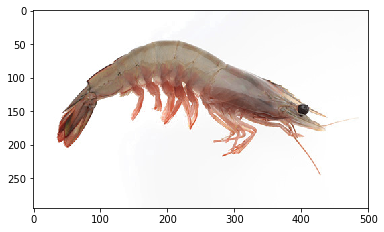

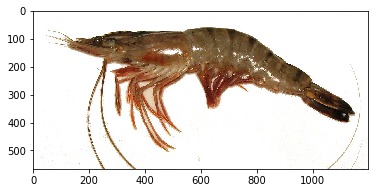

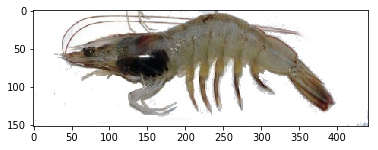

In [22]:
filepath1 = "image/kategori1/good1.jpg"
filepath2 = "image/kategori2/good24.jpg"
filepath3 = "image/kategori3/hitam25.jpg"

img1= image_open(filepath1)
img2= image_open(filepath2)
img3= image_open(filepath3)

plot(img1)
plot(img2)
plot(img3)

# Decision Tree

In [23]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [24]:
col_names = ['Category', 'MeanH', 'MeanS', 'MeanV', 'MeanL', 'MeanA', 'MeanB', 'EntropyR', 'EntropyG', 'EntropyB', 'EntropyH', 'EntropyS', 'EntropyV', 'ContrastR', 'ContrastG', 'ContrastB', 'ContrastH', 'ContrastS', 'ContrastV', 'HomogeneityR', 'HomogeneityG', 'HomogeneityB', 'HomogeneityH', 'HomogeneityS', 'HomogeneityV', 'CorrelationR', 'CorrelationG', 'CorrelationB', 'CorrelationH', 'CorrelationS', 'CorrelationV', 'EnergyR', 'EnergyG', 'EnergyB', 'EnergyH', 'EnergyS', 'EnergyV', 'MeanGR', 'MeanGG', 'MeanGB', 'MeanGH', 'MeanGS', 'MeanGV']

dataset = pd.read_csv("features.csv", header=None, names=col_names)

In [25]:
dataset.describe()

,Category,MeanH,MeanS,MeanV,MeanL,MeanA,MeanB,EntropyR,EntropyG,EntropyB,...,EnergyB,EnergyH,EnergyS,EnergyV,MeanGR,MeanGG,MeanGB,MeanGH,MeanGS,MeanGV
count,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,42.000000,...,42.000000,42.000000,42.000000,42.000000,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01,4.200000e+01
mean,2.190476,0.130072,0.301529,155.734707,57.121160,3.095294,4.723960,4.915690,4.994827,5.057253,...,0.773135,0.810325,0.810325,0.773139,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05
std,0.740405,0.062729,0.098444,22.794059,6.989193,5.256993,7.040398,0.179472,0.132908,0.113937,...,0.089814,0.052558,0.052558,0.089811,4.098680e-21,3.888349e-21,4.064381e-21,5.291373e-22,5.291373e-22,2.993253e-21
min,1.000000,0.043386,0.122682,101.137878,38.645593,-5.502537,-9.403702,4.560203,4.672806,4.866098,...,0.448677,0.689738,0.689738,0.448675,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05
25%,2.000000,0.080429,0.252315,139.043449,53.360442,0.006601,-0.786134,4.828641,4.918701,4.995331,...,0.725253,0.771873,0.771873,0.725256,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05
50%,2.000000,0.112520,0.281296,156.631180,57.210765,1.927943,4.011226,4.947578,4.987235,5.033947,...,0.795854,0.818708,0.818708,0.795858,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05
75%,3.000000,0.176018,0.362226,177.026382,62.687393,7.349828,9.975687,5.028449,5.103502,5.146385,...,0.829147,0.845259,0.845259,0.829147,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05
max,3.000000,0.328041,0.560264,196.238235,67.591067,14.248573,19.435605,5.217605,5.324031,5.267937,...,0.902402,0.907174,0.907174,0.902403,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05,1.525879e-05


In [26]:
dataset.head()

,Category,MeanH,MeanS,MeanV,MeanL,MeanA,MeanB,EntropyR,EntropyG,EntropyB,...,EnergyB,EnergyH,EnergyS,EnergyV,MeanGR,MeanGG,MeanGB,MeanGH,MeanGS,MeanGV
0,1,0.101107,0.184258,176.768906,67.387135,0.859068,-2.493702,4.813154,4.896388,5.021854,...,0.747226,0.785150,0.785150,0.747233,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
1,1,0.178672,0.220341,131.067612,50.878603,-0.365407,-0.538887,5.091137,5.137441,5.240540,...,0.605986,0.709920,0.709920,0.606001,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
2,1,0.161140,0.227835,125.884827,48.704214,0.006155,-0.239857,5.132312,5.163081,5.241604,...,0.594996,0.704776,0.704776,0.595006,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
3,1,0.328041,0.122682,148.810333,58.037357,0.007937,-9.403702,5.010713,5.010235,5.048153,...,0.616598,0.720771,0.720771,0.616604,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015
4,1,0.043386,0.361835,147.243561,49.186772,12.480680,2.783936,5.130653,5.146210,5.150694,...,0.834686,0.849493,0.849493,0.834687,0.000015,0.000015,0.000015,0.000015,0.000015,0.000015


In [27]:
feature_cols = ['MeanH', 'MeanS', 'MeanV', 'MeanL', 'MeanA', 'MeanB', 'EntropyR', 'EntropyG', 'EntropyB', 'EntropyH', 'EntropyS', 'EntropyV', 'ContrastR', 'ContrastG', 'ContrastB', 'ContrastH', 'ContrastS', 'ContrastV', 'HomogeneityR', 'HomogeneityG', 'HomogeneityB', 'HomogeneityH', 'HomogeneityS', 'HomogeneityV', 'CorrelationR', 'CorrelationG', 'CorrelationB', 'CorrelationH', 'CorrelationS', 'CorrelationV', 'EnergyR', 'EnergyG', 'EnergyB', 'EnergyH', 'EnergyS', 'EnergyV', 'MeanGR', 'MeanGG', 'MeanGB', 'MeanGH', 'MeanGS', 'MeanGV']
X = dataset[feature_cols] # Features
y = dataset.Category # Target variable

In [28]:
scores = {}
test_sizes = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]

for i in test_sizes:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=i, random_state=1)

    clf = DecisionTreeClassifier()

    clf = clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)
    
    scores.update({i : metrics.accuracy_score(y_test, y_pred)})

In [29]:
for size, score in scores.items():
    print(f"Test Size: {size}  \t Accuracy: {score}")

Test Size: 0.2  	 Accuracy: 0.6666666666666666
Test Size: 0.25  	 Accuracy: 0.6363636363636364
Test Size: 0.3  	 Accuracy: 0.7692307692307693
Test Size: 0.35  	 Accuracy: 0.6
Test Size: 0.4  	 Accuracy: 0.6470588235294118
Test Size: 0.45  	 Accuracy: 0.5263157894736842
Test Size: 0.5  	 Accuracy: 0.47619047619047616
Test Size: 0.55  	 Accuracy: 0.3333333333333333
Test Size: 0.6  	 Accuracy: 0.2692307692307692
Test Size: 0.65  	 Accuracy: 0.39285714285714285
Test Size: 0.7  	 Accuracy: 0.43333333333333335
Test Size: 0.75  	 Accuracy: 0.46875


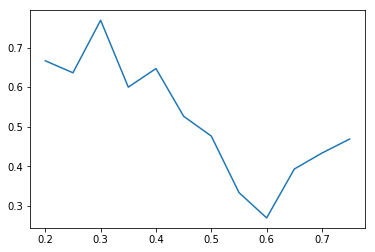

In [30]:
sort = sorted(scores.items())
size, score = zip(*sort)

plt.figure()
plt.plot(size, score)
plt.show()

In [31]:
size = 0.3

scores2 = {}
max_depth = list(range(1,10))
max_depth.append(10)
max_depth.append(15)

for i in max_depth:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=1)

    clf = DecisionTreeClassifier(max_depth=i)

    clf = clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)
    
    scores2.update({i : metrics.accuracy_score(y_test, y_pred)})

In [32]:
for depth, score in scores2.items():
    print(f"Max Depth: {depth}  \t Accuracy: {score}")

Max Depth: 1  	 Accuracy: 0.6923076923076923
Max Depth: 2  	 Accuracy: 0.46153846153846156
Max Depth: 3  	 Accuracy: 0.6923076923076923
Max Depth: 4  	 Accuracy: 0.7692307692307693
Max Depth: 5  	 Accuracy: 0.7692307692307693
Max Depth: 6  	 Accuracy: 0.6923076923076923
Max Depth: 7  	 Accuracy: 0.7692307692307693
Max Depth: 8  	 Accuracy: 0.7692307692307693
Max Depth: 9  	 Accuracy: 0.7692307692307693
Max Depth: 10  	 Accuracy: 0.6923076923076923
Max Depth: 15  	 Accuracy: 0.7692307692307693


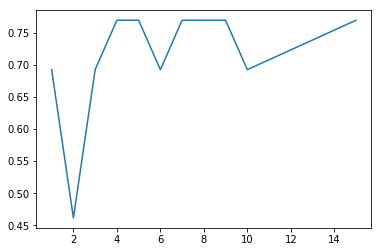

In [33]:
sort = sorted(scores2.items())
depth, score = zip(*sort)

plt.figure()
plt.plot(depth, score)
plt.show()

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

clf = DecisionTreeClassifier(max_depth=7)

clf = clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

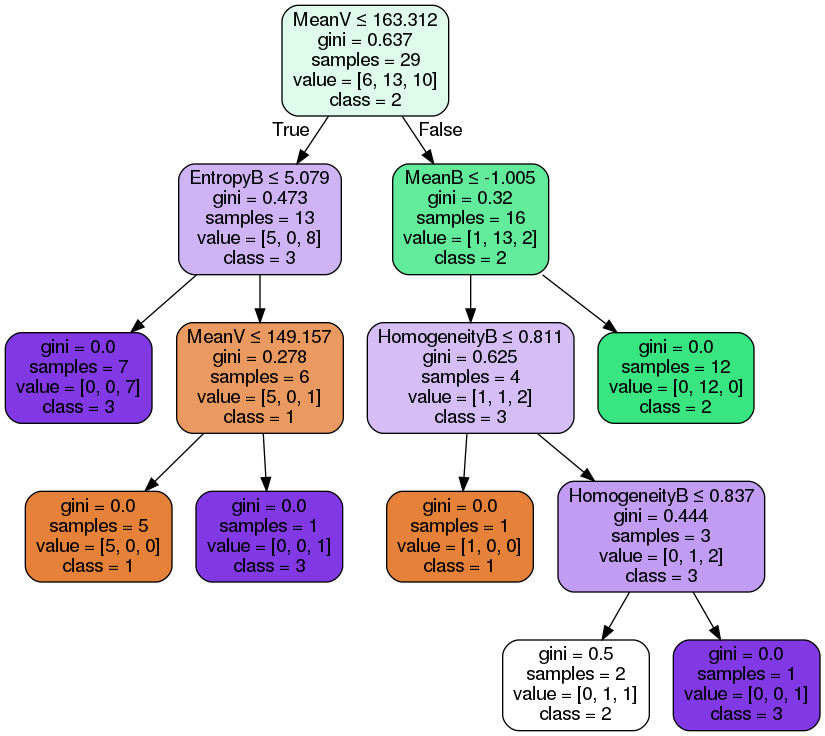

In [35]:
from sklearn.externals.six import StringIO  
from IPython.display import Image as Im
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,
                class_names=['1','2','3'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Im(graph.create_png())

In [36]:
print('Accuracy: ', metrics.accuracy_score(y_test, y_pred))

Accuracy:  0.7692307692307693


# Linear Discriminant Analysis

In [37]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [39]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [40]:
lda = LinearDiscriminantAnalysis()
X_train = lda.fit_transform(X_train, y_train)
X_test = lda.transform(X_test)

/home/rome/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


In [41]:
classifier = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=0)

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [42]:
print('Accuracy: ' + str(accuracy_score(y_test, y_pred)))

Accuracy: 0.8461538461538461


# K Nearest Neighbor Classifier

In [43]:
from sklearn.neighbors import KNeighborsClassifier

In [44]:
model = KNeighborsClassifier()

model.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [45]:
predicted= model.predict(X_test)

In [46]:
print('Accuracy: ' + str(accuracy_score(y_test, predicted)))

Accuracy: 0.5384615384615384


# Tested

In [54]:
def calculatedTexture(img):
    
    new_img = replace_background(img)
    
    h_mean = getColorMean(new_img, 0, colorrange="hsv")
    s_mean = getColorMean(new_img, 1, colorrange="hsv")
    v_mean = getColorMean(new_img, 2, colorrange="hsv")
    l_mean = getColorMean(new_img, 0, colorrange="lab")
    a_mean = getColorMean(new_img, 1, colorrange="lab")
    b_mean = getColorMean(new_img, 2, colorrange="lab")
                
    # Get Entropy RGB and HSV
               
    r_ent = calculateEntropy(new_img, 0, colorrange="rgb")
    g_ent = calculateEntropy(new_img, 1, colorrange="rgb")
    b_ent = calculateEntropy(new_img, 2, colorrange="rgb")
    h_ent = calculateEntropy(new_img, 0, colorrange="hsv")
    s_ent = calculateEntropy(new_img, 1, colorrange="hsv")
    v_ent = calculateEntropy(new_img, 2, colorrange="hsv")
                
    # To GLCM
                
    GLCMR = toGLCM(new_img, 0)
    GLCMG = toGLCM(new_img, 1)
    GLCMB = toGLCM(new_img, 2)
    GLCMH = toGLCM(new_img, 0, "hsv")
    GLCMS = toGLCM(new_img, 1, "hsv")
    GLCMV = toGLCM(new_img, 2, "hsv")
                
    # Get Contrast RGB and HSV
                
    contR = getGLCMTexture(GLCMR, properties='contrast')[0][0]
    contG = getGLCMTexture(GLCMG, properties='contrast')[0][0]
    contB = getGLCMTexture(GLCMB, properties='contrast')[0][0]
    contH = getGLCMTexture(GLCMH, properties='contrast')[0][0]
    contS = getGLCMTexture(GLCMS, properties='contrast')[0][0]
    contV = getGLCMTexture(GLCMV, properties='contrast')[0][0]
                
    # Get Homo
                
    homoR = getGLCMTexture(GLCMR, properties='homogeneity')[0][0]
    homoG = getGLCMTexture(GLCMG, properties='homogeneity')[0][0]
    homoB = getGLCMTexture(GLCMB, properties='homogeneity')[0][0]
    homoH = getGLCMTexture(GLCMH, properties='homogeneity')[0][0]
    homoS = getGLCMTexture(GLCMS, properties='homogeneity')[0][0]
    homoV = getGLCMTexture(GLCMV, properties='homogeneity')[0][0]
                
    # Get Correlation
                
    corrR = getGLCMTexture(GLCMR, properties='correlation')[0][0]
    corrG = getGLCMTexture(GLCMG, properties='correlation')[0][0]
    corrB = getGLCMTexture(GLCMB, properties='correlation')[0][0]
    corrH = getGLCMTexture(GLCMH, properties='correlation')[0][0]
    corrS = getGLCMTexture(GLCMS, properties='correlation')[0][0]
    corrV = getGLCMTexture(GLCMV, properties='correlation')[0][0]
                
    # Get Energy
                
    eneR = getGLCMTexture(GLCMR, properties='energy')[0][0]
    eneG = getGLCMTexture(GLCMG, properties='energy')[0][0]
    eneB = getGLCMTexture(GLCMB, properties='energy')[0][0]
    eneH = getGLCMTexture(GLCMH, properties='energy')[0][0]
    eneS = getGLCMTexture(GLCMS, properties='energy')[0][0]
    eneV = getGLCMTexture(GLCMV, properties='energy')[0][0]
                
    # Get Mean
    
    meanGR = np.mean(GLCMR)
    meanGG = np.mean(GLCMG)
    meanGB = np.mean(GLCMB)
    meanGH = np.mean(GLCMH)
    meanGS = np.mean(GLCMS)
    meanGV = np.mean(GLCMV)
    
    values = np.array([h_mean,s_mean,v_mean,l_mean,a_mean,b_mean,r_ent,g_ent,b_ent,h_ent,s_ent,v_ent,contR,contG,contB,contH,contS,contV,homoR,homoG,homoB,homoH,homoS,homoV,corrR,corrG,corrB,corrH,corrS,corrV,eneR,eneG,eneB,eneH,eneS,eneV,meanGR,meanGG,meanGB,meanGH,meanGS,meanGV])
    
    return values

# The Result Should be Category 2

For some reason, the above folder reader reads /kategori3/ before /kategori1/, so its now

/kategori1/ -> Category 2

/kategori2/ -> Category 3

/kategori3/ -> Category 1

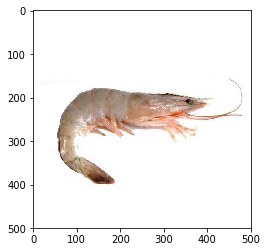

In [68]:
path = "image/kategori1/good9.jpg"
im = image_open(path)
plot(im)
result = calculatedTexture(im)
result = result.reshape(1,-1)

In [69]:
pred = clf.predict(result)

In [70]:
print(pred)

[2]
